In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.set_printoptions(precision=2)

In [3]:
X = np.random.rand(500, 50) + np.random.randn(500, 50)*0.2
X[:,0] = 1.

In [4]:
beta = np.random.randn(50)*5
idx = np.random.randint(0, 50, size=20)
beta[idx] = 0.
print(beta)

[ 2.14  0.   -6.52  0.    0.    3.19  5.76 -4.38 -5.11 -0.65 -4.13  5.62
 -6.8  10.07  0.   -1.76 -3.97 -7.88 -1.26  0.57 -4.26  6.86  0.    3.66
  0.   -0.56  0.    0.   -4.55  0.    4.7  -0.72 -1.07  0.    2.39  0.
  0.23  0.    0.54  0.    0.73  0.    0.    0.74  0.   -5.68 -4.11  1.03
  0.   -2.38]


In [5]:
y = X.dot(beta) + np.random.randn(500)*10.

## efficient forward stepwise

In [6]:
def move_feature(unused_features, used_features, feature):
    unused_features.remove(feature)
    used_features.append(feature)

def get_coeff_string(beta, feature):
    if beta is not None:
        coeff_string = f" [true value: {beta[feature]:.2f}]"
    else:
        coeff_string = ""
    return coeff_string

def print_rss_drop(rss_drop, feature, verbose_level):
    if verbose_level > 2:
        print(f"    rss_drop for {feature}: {rss_drop:.2f}")

def forward_step(H, r, y, candidates, verbose_level):
    X, unused_features = candidates
    I_H = np.eye(len(H)) - H # I - H
    r_y = 2*r - y

    best_rss_drop = -1
    best_features = -1
    for feature in unused_features:
        u = X[:,feature]
        u_proj = I_H.dot(u)
        dot1 = r_y.dot(u_proj)
        dot2 = u.dot(r)
        dot3 = u.dot(u_proj)
        rss_drop = dot1 * dot2 / dot3
        print_rss_drop(rss_drop, feature, verbose_level)
        if rss_drop > best_rss_drop:
            best_rss_drop = rss_drop
            best_feature = feature
    x = X[:,best_feature]
    q = I_H.dot(x)
    q_proj_mat = np.outer(q,q)/q.dot(q)
    next_H = H + q_proj_mat
    next_r = r - q_proj_mat.dot(y)
    return next_H, next_r, best_feature

def init_H_r(X, y):
    u = X[:,0]
    H = np.outer(u,u)/u.dot(u)
    r = y - H.dot(y)
    return H, r

def print_step(step, verbose_level):
    if verbose_level > 0:
        pre = ''
        if step > 0:
            pre = '\n'
        print(f"{pre}step {step}")

def print_feature(feature, beta, verbose_level):
    if verbose_level > 0:
        coeff_string = get_coeff_string(beta, feature)
        if feature == 0:
            intercept = ' (intercept)'
        else:
            intercept = ''
        print(f"  feature: {feature}{intercept}{coeff_string}")

def print_rss(rss, verbose_level):
    if verbose_level > 1:
        print(f"  RSS: {rss:.2f}")

def forward_stepwise_regression_eff(X, y, beta=None, verbose_level=0):
    N, p = X.shape
    unused_features = list(range(p))
    used_features = []
    rss_list = []

    print_step(0, verbose_level)
    print_feature(0, beta, verbose_level)
    move_feature(unused_features, used_features, 0)
    H, r = init_H_r(X, y)
    rss = r.dot(r)
    rss_list.append(rss)
    print_rss(rss, verbose_level)

    for i in range(1, p):
        print_step(i, verbose_level)

        candidates = (X, unused_features)
        H, r, best_feature = forward_step(H, r, y, candidates, verbose_level)
        move_feature(unused_features, used_features, best_feature)
        rss = r.dot(r)
        rss_list.append(rss)

        print_feature(best_feature, beta, verbose_level)
        print_rss(rss, verbose_level)
    return rss_list, used_features

In [7]:
rss_list, features = forward_stepwise_regression_eff(X, y, beta, verbose_level=1)

step 0
  feature: 0 (intercept) [true value: 2.14]

step 1
  feature: 13 [true value: 10.07]

step 2
  feature: 45 [true value: -5.68]

step 3
  feature: 17 [true value: -7.88]

step 4
  feature: 16 [true value: -3.97]

step 5
  feature: 12 [true value: -6.80]

step 6
  feature: 23 [true value: 3.66]

step 7
  feature: 2 [true value: -6.52]

step 8
  feature: 21 [true value: 6.86]

step 9
  feature: 5 [true value: 3.19]

step 10
  feature: 20 [true value: -4.26]

step 11
  feature: 6 [true value: 5.76]

step 12
  feature: 11 [true value: 5.62]

step 13
  feature: 30 [true value: 4.70]

step 14
  feature: 28 [true value: -4.55]

step 15
  feature: 8 [true value: -5.11]

step 16
  feature: 47 [true value: 1.03]

step 17
  feature: 10 [true value: -4.13]

step 18
  feature: 18 [true value: -1.26]

step 19
  feature: 41 [true value: 0.00]

step 20
  feature: 3 [true value: 0.00]

step 21
  feature: 31 [true value: -0.72]

step 22
  feature: 4 [true value: 0.00]

step 23
  feature: 7 [true 

In [8]:
features[:15]

[0, 13, 45, 17, 16, 12, 23, 2, 21, 5, 20, 6, 11, 30, 28]

In [9]:
rss_list[14] / rss_list[0]

0.5854503284128115

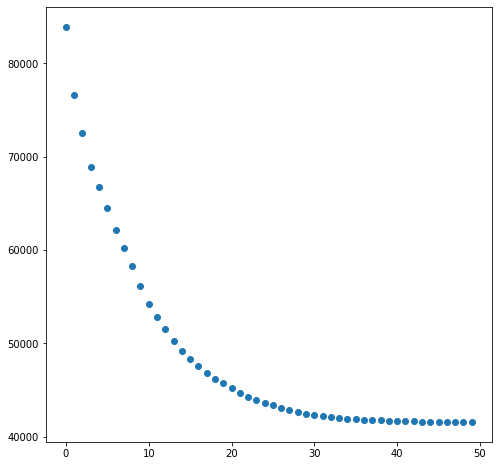

In [10]:
plt.figure(figsize=(8,8))
plt.scatter(range(len(rss_list)), rss_list)

## with Q, R

In [11]:
def step(Q, R, X, y, feature):
    H = Q.dot(Q.T)
    feature_vec = X[:,feature]
    feature_vec_sign = feature_vec - H.dot(feature_vec)
    alpha = np.linalg.norm(feature_vec_sign)
    feature_vec_sign /= alpha
    R_next = np.column_stack([np.row_stack([R, np.zeros(R.shape[1])]),
                              np.concatenate([Q.T.dot(feature_vec), [alpha]])])
    Q_next = np.column_stack([Q, feature_vec_sign])
    H_next = Q_next.dot(Q_next.T)
    y_hat = H_next.dot(y)
    r = y - y_hat
    rss = np.linalg.norm(r)**2
    return Q_next, R_next, rss

def move_feature(unused_features, used_features, feature):
    unused_features.remove(feature)
    used_features.append(feature)

def init_QR_rss(X, y):
    f = X[:,0]
    alpha = np.linalg.norm(f)
    Q = X[:, 0:1] / alpha
    R = np.array([[alpha]])
    H = Q.dot(Q.T)
    y_hat = H.dot(y)
    r = y - y_hat
    rss = np.linalg.norm(r)**2
    return Q, R, rss

def get_coeff_string(beta, feature):
    if beta is not None:
        coeff_string = f" [true value: {beta[feature]:.2f}]"
    else:
        coeff_string = ""
    return coeff_string

def forward_stepwise_regression(X, y, beta=None, verbose_level=0):
    N, p = X.shape
    unused_features = list(range(p))
    used_features = []
    rss_list = []

    print_step(0, verbose_level)
    coeff_string = get_coeff_string(beta, 0)
    print_feature(0, beta, verbose_level)
    move_feature(unused_features, used_features, 0)
    Q, R, rss = init_QR_rss(X, y)
    rss_list.append(rss)
    print_rss(rss, verbose_level)

    for i in range(1, p):
        print_step(i, verbose_level)

        best_rss_drop = -1
        best_feature = -1
        for feature in unused_features:
            _, _, rss_ = step(Q, R, X, y, feature)
            rss_drop = rss - rss_
            print_rss_drop(rss_drop, feature, verbose_level)
            if rss_drop > best_rss_drop:
                best_rss_drop = rss_drop
                best_feature = feature
        move_feature(unused_features, used_features, best_feature)
        Q, R, rss = step(Q, R, X, y, best_feature)
        rss_list.append(rss)
        coeff_string = get_coeff_string(beta, best_feature)
        print_feature(best_feature, beta, verbose_level)
        print_rss(rss, verbose_level)
    return rss_list, used_features

In [12]:
rss_list, features = forward_stepwise_regression(X, y, beta, verbose_level=1)

step 0
  feature: 0 (intercept) [true value: 2.14]

step 1
  feature: 13 [true value: 10.07]

step 2
  feature: 45 [true value: -5.68]

step 3
  feature: 17 [true value: -7.88]

step 4
  feature: 16 [true value: -3.97]

step 5
  feature: 12 [true value: -6.80]

step 6
  feature: 23 [true value: 3.66]

step 7
  feature: 2 [true value: -6.52]

step 8
  feature: 21 [true value: 6.86]

step 9
  feature: 5 [true value: 3.19]

step 10
  feature: 20 [true value: -4.26]

step 11
  feature: 6 [true value: 5.76]

step 12
  feature: 11 [true value: 5.62]

step 13
  feature: 30 [true value: 4.70]

step 14
  feature: 28 [true value: -4.55]

step 15
  feature: 8 [true value: -5.11]

step 16
  feature: 47 [true value: 1.03]

step 17
  feature: 10 [true value: -4.13]

step 18
  feature: 18 [true value: -1.26]

step 19
  feature: 41 [true value: 0.00]

step 20
  feature: 3 [true value: 0.00]

step 21
  feature: 31 [true value: -0.72]

step 22
  feature: 4 [true value: 0.00]

step 23
  feature: 7 [true 

In [13]:
features[:15]

[0, 13, 45, 17, 16, 12, 23, 2, 21, 5, 20, 6, 11, 30, 28]

In [14]:
rss_list[14] / rss_list[0]

0.5854503284128114

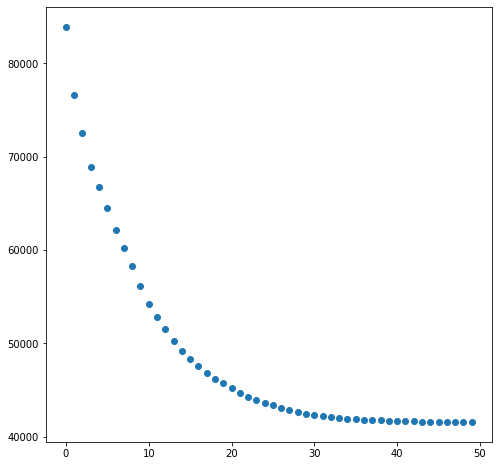

In [15]:
plt.figure(figsize=(8,8))
plt.scatter(range(len(rss_list)), rss_list)